# Art Curation and Taste Prediction

This winter, I took fast.ai's [Practical Deep Learning](http://course.fast.ai/) class, where we learned how to create deep learning models.  We used the library [fastai](https://github.com/fastai/), which sits on top of PyTorch.  I came into the class thinking about taste in art and whether I could model it with neural nets.

I have the Google Arts & Culture [extension](https://chrome.google.com/webstore/detail/google-arts-culture/akimgimeeoiognljlfchpbkpfbmeapkh?hl=en) that shows me an artwork from their collection everytime I open a new tab.  The artwork changes daily.  More than a few times I've thought, "huh, I really like this!" only to click through and realize I've favorited the piece before.  Last year my best friend brought up Rauschenberg's [*White Painting*](https://www.sfmoma.org/artwork/98.308.A-C), and I responded that I really liked it.  She then reminded me of the long, spirited, non-rancorous argument we had about the painting 7 years ago after a visit to SFMOMA.

Therefore, I think there is something consistent about my taste.  However, it's not something I can put a finger on myself.  I tend to like conceptual art, Arte Povera, and textile art, but I like a lot of stuff not in those categories.  There's a mix of style, subject, and medium.  Can a deep learning model figure my taste out?  This is my motivating question.

## Data Collection

Since Google Arts & Culture inspired my project, I obviously wanted to obtain their images.  However, that wasn't possible.  I also tried downloading MOMA's images, as I heard news that they're [opensourcing their collection](https://medium.com/digital-moma/thousands-of-exhausted-things-or-why-we-dedicated-moma-s-collection-data-to-the-public-domain-7e0a7165e99), but alas that does not contain images.  

Thankfully, it occured to me that I've been following the Twitter account [@womensart1](twitter.com/womensart1) for a while now and it's a perfect source of images. It's easy scraping images off Twitter using the [twitter-image-downloader](https://github.com/morinokami/twitter-image-downloader) library, and I got 2100 images off @womensart1.

I was worried that wasn't enough data, so I also found the Twitter account [@artpicschannel](twitter.com/artpicschannel) and downloaded 3100 images.  That account has less fine art than @womensart1; sometimes it posts, in spurts, celebrity gifs or jokes.  

Since the motivation of this project is to see if my taste is consistent enough a neural net can predict it, I labeled 1000 images from @womensart1 whether or not I liked them.  In total I liked 290 images.

## Curator Identification

As noted above, the two Twitter accounts I downloaded images from post different things.  A lot of @artpicschannel's images are mid-21st-century Impressionism, while @womensart1 has a lot more contemporary art and different mediums.  The curators of the accounts have different tastes.

I figured that one interesting step in this project would be to predict which Twitter account each image comes from. This doesn't require me to label 1000 images, and is also a larger dataset. 

First, I use ResNet-34, the architecture most used in the fast.ai class, to build a classifier.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/art_twitters/'
# Rule of thumb in the class is to choose an image size close to ImageNet
sz = 299 

In [4]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      0.63804 0.49568 0.76854]                          
[1.      0.53725 0.48822 0.78083]                          
[2.      0.48607 0.45896 0.80854]                          
[3.      0.44682 0.4671  0.80875]                          
[4.      0.42714 0.44387 0.79688]                          



The most salient paper I've found that touches upon art taste is "A Neural Algorithm of Artistic Style" (*Gatys et al*).  In that paper, they use VGG19.  So I want to compare the two.

In [30]:
arch_vgg = vgg19
data_vgg = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch_vgg, sz))

In [31]:
learn_vgg = ConvLearner.pretrained(arch_vgg, data_vgg, precompute=True)
learn_vgg.fit(0.01,5)

100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      0.62736 0.51246 0.75708]                          
[1.      0.55315 0.47589 0.76958]                          
[2.      0.50358 0.44897 0.79312]                          
[3.      0.47907 0.44068 0.79312]                          
[4.      0.44713 0.41214 0.79792]                          



Out-of-the-box, both have similar performance.  They both may be beginning to overfit -- in the last epoch the training error is less than the validation error.  

Next, I'll try to find a better learning rate using the fastai function lr_find().  It's based off [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf) from Leslie N. Smith.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 51/58 [00:00<00:00, 62.86it/s, loss=2.7]  


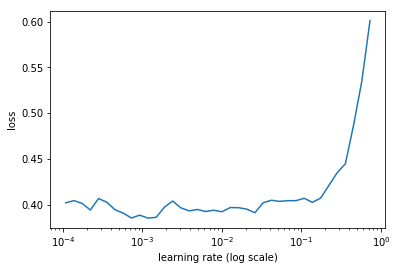

In [34]:
learn.lr_find()
learn.sched.plot()

The graph above tells me that loss jumps up around learning rate 0.1, but before that the loss tends to be the same.  I'll stick to my starting learning rate of 0.01.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 45%|████▍     | 26/58 [00:00<00:00, 32.11it/s, loss=1.96] 


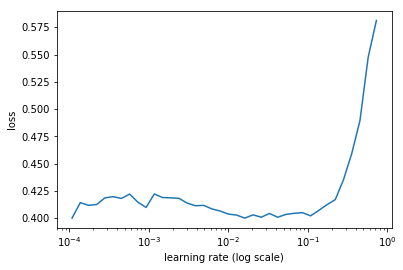

In [35]:
learn_vgg.lr_find()
learn_vgg.sched.plot()

The same plot for the VGG19 CNN indicates that 0.001 would be a better learning rate.

Next, I will unfreeze all the layers of my CNNs and retrain them.  They were both trained on ImageNet, and my artworks are not very similar.  I use the rule of thumb that each previous layer is trained 

In [ ]:
learn.unfreeze()
learn_vgg.unfreeze()

In [ ]:
learn.fit([1e-4, 1e-3, 1e-2], 3)

The Practical Deep Learning class also recommended a rule of thumb to cosine anneal the learning rate, with cycle length 1 and cycle multiplicity 2.

In [ ]:
learn.fit([1e-4, 1e-3, 1e-2], 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn_vgg.fit([1e-5, 1e-4, 1e-3], 3)

In [ ]:
learn_vgg.fit([1e-5, 1e-4, 1e-3], 3, cycle_len=1, cycle_mult=2)

Okay, how do I contextualize the success of these CNNs?  I think the best way to benchmark it in this project is to see if it outperforms humans.  Therefore, I look at random images from @artpicschannel and @womensart1 and guess which account the artwork came from.

I've looked at 1000 images from @womensart1 to judge whether or not I like them (see "Data Collection), so I must remove them from this pool.  So out of 3000 @artpicschannel and 1000 @womensart1 images, I label about 500 randomly.

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

human_classification = pd.read_csv('whichchannel_labels.csv', header=None)
print(len(human_classification), sum(human_classification[1]), sum(human_classification[2]))
# Number of labeled images, Number of true @womensart1 images, Number of guessed @womensart1 images

In [ ]:
cm = confusion_matrix(human_classification[1], human_classification[2])
plot_confusion_matrix(cm, ['@artpicschannel', '@womensart1'])

My success rate is 85.6%, meaning that the CNNs perform about as well as I do!  I find this surprising and very impressive.

## Personal Taste in Art

Now to the part of this project that originally motivated me: whether an neural net can predict what artwork I like, since I can't even identify it myself.  To that end, I labeled 1000 images from @womensart1.

In [84]:
# Get indices of rows to hold back as validation set
fnames,y,classes = csv_source('womensart', 'womensart_labels.csv')
val_idxs = get_cv_idxs(len(fnames)-1)

In [85]:
data_taste = ImageClassifierData.from_csv(PATH, 'womensart', 'womensart_labels.csv',
                                          val_idxs=val_idxs,tfms=tfms_from_model(arch, sz))

In [111]:
learn_taste = ConvLearner.pretrained(arch, data_taste, precompute=True)
learn_taste.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      1.23774 0.89784 0.59896]                        
[1.      0.98254 0.71509 0.67969]                         
[2.      0.82321 0.73383 0.66797]                         
[3.      0.72432 0.75607 0.67188]                         
[4.      0.65921 0.74686 0.67578]                         



In [112]:
# Try both ResNet34 and VGG19, as above.
data_taste_vgg = ImageClassifierData.from_csv(PATH, 'womensart', 'womensart_labels.csv',
                                          val_idxs=val_idxs,tfms=tfms_from_model(arch_vgg, sz))
learn_taste_vgg = ConvLearner.pretrained(arch_vgg, data_taste_vgg, precompute=True)
learn_taste_vgg.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      1.22868 0.87063 0.67057]                        
[1.      0.96921 0.79374 0.67448]                         
[2.      0.82154 0.78069 0.67057]                         
[3.      0.73128 0.77534 0.67057]                         
[4.      0.6586  0.76409 0.65755]                         



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.44747 0.7351  0.69531]                         



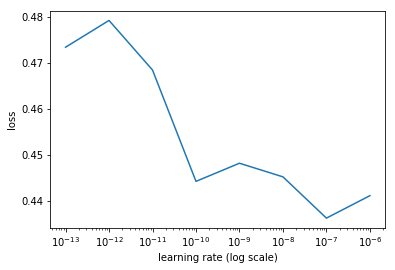

In [113]:
# Try to find an a better learning rate.
# Learning rate finder for ResNet-34 CNN
learn_taste.lr_find(start_lr=10e-14, end_lr=1)
learn_taste.sched.plot(n_skip=0)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.46763 0.84606 0.64323]                         



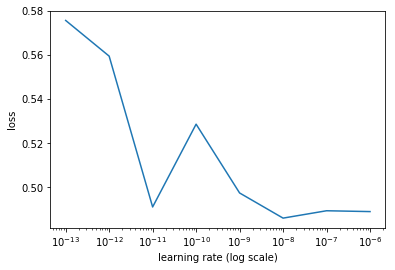

In [114]:
# Learning rate finder for VGG19 CNN
learn_taste_vgg.lr_find(start_lr=10e-14, end_lr=1)
learn_taste_vgg.sched.plot(n_skip=0)

Hmm, something that strikes me is that these learning rate graphs don't look like the ones in the previous section.  There's not a big range of learning rates that give approximately the same loss, and these are much less monotonic.  Given that the accuracies are lower, these LR graphs seem to also indicate that taste prediction is harder than curator prediction.

10e-7 and 10e-8 seem to be best, though that jumps around on each run.

In [115]:
# Unfreeze 
learn_taste.unfreeze()
learn_taste_vgg.unfreeze()

In [116]:
lr = np.array([10e-9,10e-8,10e-7])
learn_taste.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.42524 0.74897 0.67969]                          
[1.      0.44349 0.74549 0.67188]                          
[2.      0.45097 0.74963 0.67578]                          
[3.      0.4574  0.74982 0.67188]                          
[4.      0.46493 0.7489  0.66797]                          
[5.      0.46475 0.74606 0.67188]                          
[6.      0.46247 0.74719 0.66797]                          



In [117]:
learn_taste_vgg.fit([10e-10,10e-9,10e-8], 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.50985 0.76602 0.64974]                          
[1.      0.48545 0.76458 0.64974]                          
[2.      0.47822 0.76626 0.65365]                          
[3.      0.48619 0.76636 0.64974]                          
[4.      0.49021 0.76572 0.64193]                          
[5.      0.48825 0.76792 0.64974]                          
[6.      0.48298 0.76644 0.65755]                          



Unfreezing leads to strong overfitting here, as the validation loss doesn't change due to unfreezing.  Going off the unfrozen nets,  ResNet-34 and VGG can predict artwork I'd like with 67% and 65% accuracy.

67% accuracy is pretty impressive to me.  I don't have a human benchmark -- I don't know if I'll be able to pay someone to assiduously study my taste before labeling images -- but given that I only scored 85% on the previous task, I think 67% is still good.  I may need to label more images for the neural network.

# Next Steps

I'm very curious about interpretability. What can I learn about my own taste from the neural nets I trained?  Just through labeling 1000 images, I learned that I liked black-and-white photography much more and textile art less than I thought did.  I bet I can learn a lot more by inspecting the CNNs.  [This paper on visualizing CNNs](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) is next on my reading list.

I'd also like to reduce the overfitting on the unfrozen nets.  I know increasing drop-out is one strategy, but I'd like to learn others.

